In [1]:
from torch_geometric.nn.models import AttentiveFP
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from rdkit import Chem
import torch.nn.functional as F
import torch
import pandas as pd 
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
from clsar2.dataset import LSSNS, HSSMS  # dataset
from clsar2.feature import GenNodeEdgeFeatures115, GenNodeEdgeFeatures39  # feature
from clsar2.model.model import ACANet_GCN, ACANet_GIN, ACANet_GAT, ACANet_PNA, get_deg  # model
from clsar2.model.pooling import SubstructurePool
from clsar2.model.loss import ACALoss
from clsar2.model.saver import SaveBestModel

In [4]:
Dataset = HSSMS

lr = 1e-4
epochs = 200
batch_size = 32
fp_dim = 1024

pre_transform = GenNodeEdgeFeatures39(nBits = fp_dim, radius = 2) #nBits = fp_dim, radius = 2
dataset_name = 'chembl4203_ki'

edge_dim = pre_transform.edge_dim
in_channels = pre_transform.in_channels

In [5]:
results = [] 

path = './tmpignore/%s_%s_%s' % (pre_transform.in_channels, pre_transform.fp_type, fp_dim)
dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform)

split = pd.Series(dataset.data.split)
train_idx = split[split == 'train'].index.tolist()
test_idx = split[split == 'test'].index.tolist()

train_dataset = dataset.index_select(train_idx)
test_dataset = dataset.index_select(test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


train_y = dataset.data.y[train_idx]
test_y = dataset.data.y[test_idx]

In [6]:
deg = get_deg(train_dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
pub_args = {'in_channels': in_channels, 
            'out_channels': 1, 
            'fp_dim':fp_dim, 
             'edge_dim': edge_dim, 
             'convs_layers': [128, 64, 1], 
             'dense_layers':[512, 128, 32],
             'pooling_layer': SubstructurePool('mean'),
             'dropout_p': 0.0, 'batch_norms': torch.nn.BatchNorm1d} # ,'batch_norms': 

model = ACANet_PNA(**pub_args, deg=deg, aggregators=['mean', 'min', 'max', 'sum'], 
                     scalers=['identity', 'amplification', 'attenuation']).to(device)

aca_loss = ACALoss(alpha = 1., cliff_lower = 1., cliff_upper=1., dev_mode=False)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5) #

saver = SaveBestModel(data_transformer = train_dataset.smiles_to_data, 
                      save_dir = './', save_name = '%s' % dataset_name)

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
def train(train_loader):
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        x, out, embed = model(data.x.float(), data.edge_index,
                           data.edge_attr, data.batch, data.fp)
        #loss = F.mse_loss(out, data.y)
        loss = aca_loss(data.y, out, embed)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)

@torch.no_grad()
def test(loader, model):
    mse = []
    for data in loader:
        data = data.to(device)
        x, out, embed = model.eval()(data.x.float(), data.edge_index,
                           data.edge_attr, data.batch, data.fp)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())


@torch.no_grad()
def predict(test_loader, model):
    #embeds = []
    preds = []
    for data in test_loader:
        data = data.to(device)
        E = model.eval()
        x, predictions, embeddings = E(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch, data.fp)
        #embeds.append(embeddings)
        preds.append(predictions)
    #embeddings = torch.concat(embeds, axis=0).cpu().numpy()
    predictions = torch.concat(preds, axis=0)
    return predictions

In [9]:
history = []
for epoch in range(1, epochs):
    train_rmse = train(train_loader)
    #val_rmse = test(val_loader)
    saver(train_rmse, epoch, model, optimizer)
    
    test_rmse = test(test_loader, model)
    print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Test: {test_rmse:.4f}')
    history.append({'Epoch': epoch, 'train_rmse': train_rmse,'test_rmse': test_rmse})

df = pd.DataFrame(history)

Epoch: 001, Loss: 3.0427 Test: 6.6792
Epoch: 002, Loss: 2.7986 Test: 6.6565
Epoch: 003, Loss: 2.7879 Test: 6.6296
Epoch: 004, Loss: 2.7837 Test: 6.5925
Epoch: 005, Loss: 2.7665 Test: 6.5436
Epoch: 006, Loss: 2.7557 Test: 6.4551
Epoch: 007, Loss: 2.7312 Test: 6.2488
Epoch: 008, Loss: 2.6782 Test: 5.6272
Epoch: 009, Loss: 2.4554 Test: 2.0181
Epoch: 010, Loss: 1.9614 Test: 1.7971
Epoch: 011, Loss: 1.8488 Test: 1.7106
Epoch: 012, Loss: 1.7580 Test: 1.5362
Epoch: 013, Loss: 1.6539 Test: 1.2782
Epoch: 014, Loss: 1.6005 Test: 1.3410
Epoch: 015, Loss: 1.5405 Test: 1.1885
Epoch: 016, Loss: 1.5034 Test: 1.1750
Epoch: 017, Loss: 1.4720 Test: 1.1908
Epoch: 018, Loss: 1.4454 Test: 1.1224
Epoch: 019, Loss: 1.4228 Test: 1.1271
Epoch: 020, Loss: 1.4157 Test: 1.0925
Epoch: 021, Loss: 1.3944 Test: 1.1271
Epoch: 022, Loss: 1.3859 Test: 1.0862
Epoch: 023, Loss: 1.3611 Test: 1.0225
Epoch: 024, Loss: 1.3691 Test: 1.0113
Epoch: 025, Loss: 1.3586 Test: 1.0928
Epoch: 026, Loss: 1.3638 Test: 1.1593
Epoch: 027, 

In [10]:
model.load_state_dict(saver.inMemorySave['model_state_dict'])
test_pred = predict(test_loader, model)
y_true = test_y.cpu().numpy().reshape(-1, ) 
y_pred = test_pred.cpu().numpy().reshape(-1, )    
cliff_flag = dataset.data.cliff[test_idx].cpu().numpy()
dfp = pd.DataFrame([y_true, y_pred, cliff_flag]).T
dfp.columns = ['y_true', 'y_pred', 'cliff_flag']

## calculate the overall rmse and cliff rmse of the test set
overall_rmse = np.sqrt(np.mean(np.square(dfp.y_true - dfp.y_pred)))
g = dfp.groupby('cliff_flag')
noncliff_rmse, cliff_rmse = g.apply(lambda x:np.sqrt(np.mean(np.square(x.y_true - x.y_pred)))).to_list()

In [11]:
overall_rmse, cliff_rmse

(0.9598818644677843, 0.9553347495588231)

In [12]:
test(test_loader, model)

0.959881603717804

<AxesSubplot:>

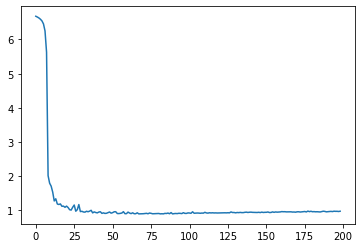

In [13]:
df.test_rmse.plot() #iloc[20:].

In [14]:
model.model_args

{'in_channels': 39,
 'out_channels': 1,
 'edge_dim': 10,
 'fp_dim': 1024,
 'convs_layers': [128, 64, 1],
 'dropout_p': 0.0,
 'batch_norms': ModuleList(
   (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 'pooling_layer': <clsar2.model.pooling.SubstructurePool at 0x7fe517049400>,
 'dense_layers': [512, 128, 32],
 'deg': tensor([   0, 1819, 7704, 4669,   95]),
 'aggregators': ['mean', 'min', 'max', 'sum'],
 'scalers': ['identity', 'amplification', 'attenuation']}

In [15]:
overall_rmse, cliff_rmse

(0.9598818644677843, 0.9553347495588231)

In [16]:
# 0.879794	1.001433